<h1><center>Deep Learning Course - First Mini Project</center></h1>
<h3><center>Image Classification and Regression</center></h3>
<h4><center>Professor : Vincent Lepetit</center></h4>
<h5><center>Mehdi Boubnan</center></h5>

# Imports and defining functions

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
from tensorflow import set_random_seed
np.random.seed(42)
set_random_seed(1)

In [66]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, UpSampling2D, Input
from keras.optimizers import SGD, Adam
from keras import regularizers
from keras import utils as np_utils

In [4]:
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data',end=".. ")
    for i in range(nb_samples):
        #if i % 10 == 0:
            #print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    print("Done")
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data',end=".. ")
    for i in range(nb_samples):
        #if i % 10 == 0:
            #print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    print("Done")
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

# Classification Problem

## Simple Classification

### Generating data

Our training and testing datasets are composed by shapes images (rectangles, disks and triangles). We'll begin by generating some data samples :

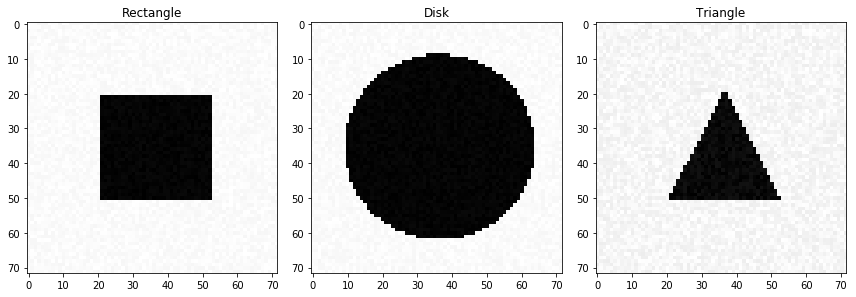

In [5]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,4))

im = generate_a_rectangle(10, False)
ax1.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax1.set_title("Rectangle")

im = generate_a_disk(10, False)
ax2.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax2.set_title("Disk")

[im, v] = generate_a_triangle(20, False)
ax3.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax3.set_title("Triangle")

plt.tight_layout()
plt.show()

We'll then generate our training dataset with **300 samples** of shapes images, and see their distribution :

In [6]:
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data.. Done


We one-hot encore the data labels to fit the model :

In [7]:
Y_train = np_utils.to_categorical(Y_train, 3)

### Building the model

We'll train a simple two layer fully-connected neural network, taking in input vectors in $\mathbb{R}^{5184}$ (our image shapes are 72x72), and outputing a vector in $\mathbb{R}^3$ representing the probabilities of belonging to each of the three classes (rectangle, disk, triangle). To do so, we use a hidden layer of **64** neurons followed by a **ReLU** activation, and an output layer of 3 neurons, followed by a **softmax** activation.

For training the data, we'll use the stochastic gradient descent optimizer, with a 0.001 learning rate, a decay of $10^{-6}$ and a momentum of 0.9.
We'll use 50 epochs and a 32 batch size.

#### Using SGD optimizer

In [8]:
model = Sequential()

output = 3

model.add(Dense(output, input_shape=(5184,)))
model.add(Activation('softmax'))

sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

Let's train the model with SGD :

In [9]:
model.fit(X_train, Y_train, epochs=50, batch_size=32)

Epoch 1/50
300/300 [==============================] - 3s 9ms/step - loss: 1.1542 - acc: 0.5000
Epoch 2/50
300/300 [==============================] - 0s 120us/step - loss: 0.6739 - acc: 0.7000
Epoch 3/50
300/300 [==============================] - 0s 96us/step - loss: 0.5286 - acc: 0.7800
Epoch 4/50
300/300 [==============================] - 0s 100us/step - loss: 0.4238 - acc: 0.8233
Epoch 5/50
300/300 [==============================] - 0s 103us/step - loss: 0.3645 - acc: 0.8900
Epoch 6/50
300/300 [==============================] - 0s 100us/step - loss: 0.3277 - acc: 0.8867
Epoch 7/50
300/300 [==============================] - 0s 96us/step - loss: 0.2687 - acc: 0.9533
Epoch 8/50
300/300 [==============================] - 0s 96us/step - loss: 0.2419 - acc: 0.9700
Epoch 9/50
300/300 [==============================] - 0s 106us/step - loss: 0.2308 - acc: 0.9433
Epoch 10/50
300/300 [==============================] - 0s 96us/step - loss: 0.2048 - acc: 0.9533
Epoch 11/50
300/300 [==============

#### Using Adam optimizer

In [24]:
model = Sequential()

hidden_neurons = 64
output = 3

model.add(Dense(output, input_shape=(5184,), kernel_regularizer=regularizers.l2(0.1)))
model.add(Activation('softmax'))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [25]:
model.fit(X_train, Y_train, epochs=50, batch_size=32)

Epoch 1/50
300/300 [==============================] - 0s 684us/step - loss: 2.2444 - acc: 0.4300
Epoch 2/50
300/300 [==============================] - 0s 110us/step - loss: 1.3535 - acc: 0.6300
Epoch 3/50
300/300 [==============================] - 0s 113us/step - loss: 1.1097 - acc: 0.7633
Epoch 4/50
300/300 [==============================] - 0s 103us/step - loss: 1.0435 - acc: 0.8233
Epoch 5/50
300/300 [==============================] - 0s 96us/step - loss: 0.9035 - acc: 0.8900
Epoch 6/50
300/300 [==============================] - 0s 103us/step - loss: 0.8417 - acc: 0.9300
Epoch 7/50
300/300 [==============================] - 0s 103us/step - loss: 0.8027 - acc: 0.9400
Epoch 8/50
300/300 [==============================] - 0s 96us/step - loss: 0.7943 - acc: 0.9167
Epoch 9/50
300/300 [==============================] - 0s 100us/step - loss: 0.7810 - acc: 0.9167
Epoch 10/50
300/300 [==============================] - 0s 100us/step - loss: 0.6871 - acc: 0.9900
Epoch 11/50
300/300 [==========

### Plotting weights

We'll plot the first three weights :

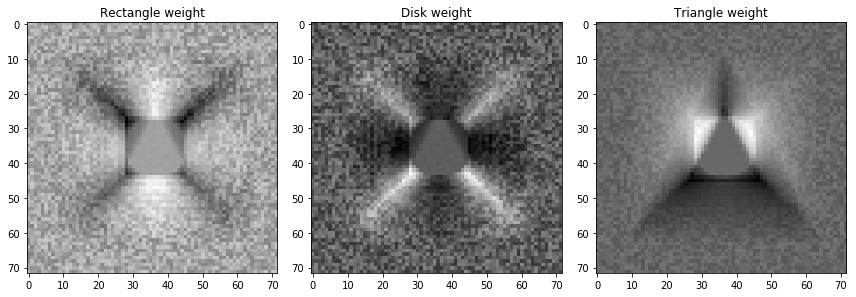

In [26]:
weights = model.get_weights()[0].T

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4))

ax1.imshow(weights[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax1.set_title("Rectangle weight")

ax2.imshow(weights[1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax2.set_title("Disk weight")

ax3.imshow(weights[2].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax3.set_title("Triangle weight")

plt.tight_layout()
plt.show()

## More Difficult Classification Problem

### Generating Data

Now, we'll generate a new training set where the shapes are allowed to move within the images and change dimensions.

In [27]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
[X_test, Y_test] = generate_test_set_classification()

Creating data.. Done
Creating data.. Done


Let's see what the new data looks like

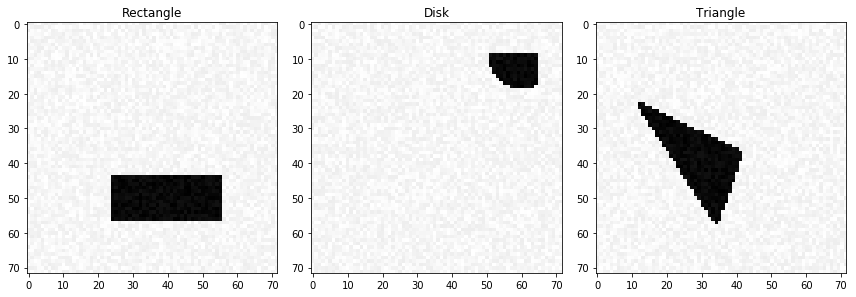

In [28]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,4))

im = generate_a_rectangle(20, True)
ax1.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax1.set_title("Rectangle")

im = generate_a_disk(20, True)
ax2.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax2.set_title("Disk")

[im, v] = generate_a_triangle(20, True)
ax3.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax3.set_title("Triangle")

plt.tight_layout()
plt.show()

Let's see now the distribution of our shapes within the train and test set

We one-hot encode the training to fit the model, the test labels are already one-hot encoded :

In [29]:
Y_train = np_utils.to_categorical(Y_train, 3)

### Retraining the model

We'll use the **same model as before**, and retrain it on the new dataset. We choose to double the number of **epochs** from **50 to 100**.

In [30]:
model = Sequential()

hidden_neurons = 64
output = 3

model.add(Dense(output, input_shape=(5184,)))
model.add(Activation('softmax'))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

Let's train our model

In [31]:
model.fit(X_train, Y_train, epochs=100, batch_size=32)

Epoch 1/100
300/300 [==============================] - 0s 694us/step - loss: 2.0480 - acc: 0.3067
Epoch 2/100
300/300 [==============================] - 0s 103us/step - loss: 1.4813 - acc: 0.3333
Epoch 3/100
300/300 [==============================] - 0s 103us/step - loss: 1.1658 - acc: 0.4300
Epoch 4/100
300/300 [==============================] - 0s 103us/step - loss: 1.0508 - acc: 0.4933
Epoch 5/100
300/300 [==============================] - 0s 100us/step - loss: 1.3319 - acc: 0.4233
Epoch 6/100
300/300 [==============================] - 0s 110us/step - loss: 0.9425 - acc: 0.5533
Epoch 7/100
300/300 [==============================] - 0s 103us/step - loss: 0.8725 - acc: 0.5700
Epoch 8/100
300/300 [==============================] - 0s 103us/step - loss: 0.8869 - acc: 0.5500
Epoch 9/100
300/300 [==============================] - 0s 96us/step - loss: 0.8764 - acc: 0.5900
Epoch 10/100
300/300 [==============================] - 0s 103us/step - loss: 0.8510 - acc: 0.6000
Epoch 11/100
300/300

Let's evaluate our model on the test set :

In [32]:
Loss, accuracy = model.evaluate(X_test, Y_test, batch_size=32)

print("Loss : {}".format(Loss))
print("Accuracy : {}".format(accuracy))

300/300 [==============================] - 0s 260us/step
Loss : 1.139453231493632
Accuracy : 0.5899999996026357


### Building a convolutional network

We notice that the performance is worse on the new dataset. We'll change the model and use a convolutional network.

The architecture :
  - Convolution with 2 by 2 filters, 16 feature maps + ReLU nonlinearity.
  - 2 by 2 max pooling
  - Convolution with 2 by 2 filter, 32 feature maps + ReLU nonlinearity.
  - 2 by 2 max pooling
  - Flattening
  - Linear layer with 64 hidden units + ReLU nonlionearity
  - Linear layer with 3 outputs units.

In [33]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import SGD
from keras import utils as np_utils

model = Sequential()
model.add(Conv2D(16, kernel_size=(2, 2), activation='relu',input_shape=(72,72,1)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [34]:
#model.summary()

We reshape the train and test sets to fit the model

In [35]:
X_train = X_train.reshape(-1,72,72,1)
X_test = X_test.reshape(-1,72,72,1)

Let's train now our model

In [36]:
model.fit(X_train, Y_train, epochs=50, batch_size=32)

Epoch 1/50
300/300 [==============================] - 2s 6ms/step - loss: 1.1694 - acc: 0.4000
Epoch 2/50
300/300 [==============================] - 0s 303us/step - loss: 1.0561 - acc: 0.4400
Epoch 3/50
300/300 [==============================] - 0s 286us/step - loss: 1.0054 - acc: 0.4967
Epoch 4/50
300/300 [==============================] - 0s 276us/step - loss: 0.9494 - acc: 0.5367
Epoch 5/50
300/300 [==============================] - 0s 276us/step - loss: 0.8654 - acc: 0.7100
Epoch 6/50
300/300 [==============================] - 0s 276us/step - loss: 0.7859 - acc: 0.7600
Epoch 7/50
300/300 [==============================] - 0s 279us/step - loss: 0.7057 - acc: 0.7933
Epoch 8/50
300/300 [==============================] - 0s 276us/step - loss: 0.6301 - acc: 0.8233
Epoch 9/50
300/300 [==============================] - 0s 279us/step - loss: 0.6130 - acc: 0.8067
Epoch 10/50
300/300 [==============================] - 0s 278us/step - loss: 0.5409 - acc: 0.8133
Epoch 11/50
300/300 [==========

Let's evaluate it using the test set

In [37]:
ConvLoss, Conv_accuracy = model.evaluate(X_test, Y_test, batch_size=32)

print("Loss : {}".format(ConvLoss))
print("Accuracy : {}".format(Conv_accuracy))

300/300 [==============================] - 0s 395us/step
Loss : 0.5055055165290833
Accuracy : 0.8333333333333334


**COMMMEEENTS**

# Regression Problem

The task now is to predict the image locations of the vertices of a triangle, given an image of this triangle.

We'll generate 300 triangles for each of the training and test set, knowing the location of the vertices.

In [43]:
[X_train, Y_train] = generate_dataset_regression(300, 20)
[X_test, Y_test] = generate_test_set_regression()

Creating data.. Done
Creating data.. Done


Let's normalize the data :

In [44]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()
Y_train_norm = normalizer.fit_transform(Y_train)#.reshape(-1,2)).reshape(Y_train.shape)

normalizer = Normalizer()
Y_test_norm = normalizer.fit_transform(Y_test)#.reshape(-1,2)).reshape(Y_test.shape)

In [45]:
from sklearn.preprocessing import StandardScaler

scaler_train = StandardScaler()
Y_train_scale0 = scaler_train.fit_transform(Y_train)

scaler_test = StandardScaler()
Y_test_scale0 = scaler_test.fit_transform(Y_test)

In [46]:
from sklearn.preprocessing import StandardScaler

scaler_train = StandardScaler()
Y_train_scale = scaler_train.fit_transform(Y_train.T).T

scaler_test = StandardScaler()
Y_test_scale = scaler_test.fit_transform(Y_test.T).T

In [47]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()
Y_train_norm_s = normalizer.fit_transform(Y_train_scale)#.reshape(-1,2)).reshape(Y_train.shape)

normalizer = Normalizer()
Y_test_norm_s = normalizer.fit_transform(Y_test_scale)#.reshape(-1,2)).reshape(Y_test.shape)

from sklearn.preprocessing import Normalizer

normalizer = Normalizer()
Y_train_norm_s0 = normalizer.fit_transform(Y_train_scale0)

normalizer = Normalizer()
Y_test_norm_s0 = normalizer.fit_transform(Y_test_scale0)

In [48]:
from sklearn.preprocessing import StandardScaler

scaler_train = StandardScaler()
Y_train_scale_n = scaler_train.fit_transform(Y_train_norm.T).T

scaler_test = StandardScaler()
Y_test_scale_n = scaler_test.fit_transform(Y_test_norm.T).T

from sklearn.preprocessing import StandardScaler

scaler_train = StandardScaler()
Y_train_scale0_n = scaler_train.fit_transform(Y_train_norm)

scaler_test = StandardScaler()
Y_test_scale0_n = scaler_test.fit_transform(Y_test_norm)

We can visualize what the data looks like :

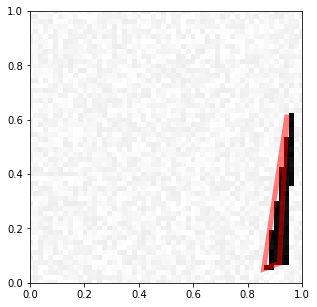

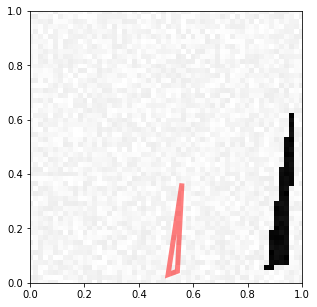

In [56]:
i=np.random.randint(X_train.shape[0])

visualize_prediction(X_train[i], Y_train[i])
visualize_prediction(X_train[i], Y_train_norm[i])
#visualize_prediction(X_train[i], Y_train_scale[i])

In [51]:
from keras import backend as K

def cos_distance(y_true, y_pred):
    y_true = K.l2_normalize(y_true, axis=-1)
    y_pred = K.l2_normalize(y_pred, axis=-1)
    return K.mean(1 - K.sum((y_true * y_pred), axis=-1))

model = Sequential()
model.add(Conv2D(16, kernel_size=(5, 5), activation='relu',input_shape=(72,72,1), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
#model.add(Dense(512, activation='relu'))
model.add(Dense(6, activation='linear'))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.5, nesterov=True)

model.compile(loss="mean_absolute_error", optimizer=adam)

In [52]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 72, 72, 16)        416       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 36, 36, 32)        12832     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 18, 18, 64)        51264     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 9, 9, 128)         204928    
__________

We reshape the train and test sets to fit the model

In [53]:
X_train = X_train.reshape(-1,72,72,1)
X_test = X_test.reshape(-1,72,72,1)

We train the model

In [54]:
model.fit(X_train, Y_train_norm_s, epochs=70, batch_size=32, validation_data=(X_test,Y_test_norm_s))

Train on 300 samples, validate on 300 samples
Epoch 1/70
300/300 [==============================] - 1s 3ms/step - loss: 0.3599 - val_loss: 0.3518
Epoch 2/70
300/300 [==============================] - 0s 698us/step - loss: 0.3470 - val_loss: 0.3437
Epoch 3/70
300/300 [==============================] - 0s 695us/step - loss: 0.3270 - val_loss: 0.3258
Epoch 4/70
300/300 [==============================] - 0s 698us/step - loss: 0.3141 - val_loss: 0.3298
Epoch 5/70
300/300 [==============================] - 0s 695us/step - loss: 0.3036 - val_loss: 0.3251
Epoch 6/70
300/300 [==============================] - 0s 695us/step - loss: 0.2985 - val_loss: 0.3237
Epoch 7/70
300/300 [==============================] - 0s 688us/step - loss: 0.2876 - val_loss: 0.3216
Epoch 8/70
300/300 [==============================] - 0s 695us/step - loss: 0.2796 - val_loss: 0.3236
Epoch 9/70
300/300 [==============================] - 0s 691us/step - loss: 0.2671 - val_loss: 0.3284
Epoch 10/70
300/300 [=================

In [23]:
model.evaluate(X_test, Y_test_norm)

300/300 [==============================] - 0s 889us/step


0.12234155535697937

In [119]:
Y_test_pred=model.predict(X_test)
Y_train_pred=model.predict(X_train)

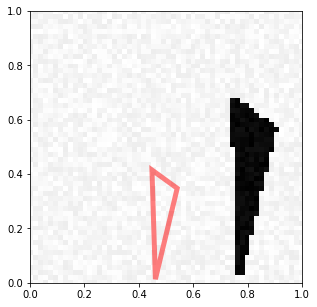

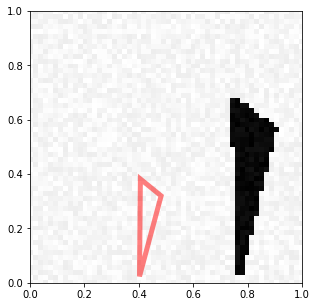

In [131]:
i=np.random.randint(300)
visualize_prediction(X_train[i], Y_train_norm[i])
#visualize_prediction(X_train[i], scaler.inverse_transform(Y_train_pred[i]))

#visualize_prediction(X_train[i], Y_train_norm[i])
visualize_prediction(X_train[i], Y_train_pred[i])

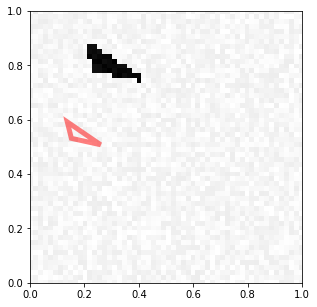

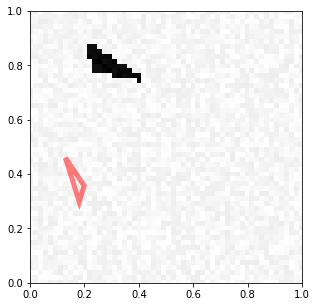

In [147]:
#visualize_prediction(X_test[i], Y_test[i])
#visualize_prediction(X_test[i], scaler.inverse_transform(Y_test_pred[i]))
i=np.random.randint(300)
visualize_prediction(X_test[i], Y_test_norm[i])
visualize_prediction(X_test[i], Y_test_pred[i])

# Image Denoising

In [113]:
def generate_dataset_denoising(nb_samples, noise=50, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X_clear = np.zeros([nb_samples,im_size])
    X_noisy = np.zeros([nb_samples,im_size])
    print('Creating data',end=".. ")
    seed = np.random.randint(99999)
    for i in range(nb_samples):
        category = np.random.randint(3)
        if category == 0:
            X_clear[i] = generate_a_rectangle_seed(np.random.RandomState(seed), 0, free_location)
            X_noisy[i] = generate_a_rectangle_seed(np.random.RandomState(seed), noise, free_location)
        elif category == 1: 
            X_clear[i] = generate_a_disk_seed(np.random.RandomState(seed), 0, free_location)
            X_noisy[i] = generate_a_disk_seed(np.random.RandomState(seed), noise, free_location)
        else:
            [X_clear[i], V] = generate_a_triangle_seed(np.random.RandomState(seed), 0, free_location)
            [X_noisy[i], V] = generate_a_triangle_seed(np.random.RandomState(seed), noise, free_location)

    X_clear = X_clear / 255
    X_noisy = (X_noisy + noise) / (255 + 2 * noise)
    print("Done")
    return [X_clear, X_noisy]

def generate_a_rectangle_seed(rng, noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = rng.uniform(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * rng.uniform()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk_seed(rng, noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = rng.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * rng.uniform()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle_seed(rng, noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = rng.random(3)
        V = rng.random(3)
    else:
        size = (0.3 + 0.7 * rng.uniform())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

In [114]:
[X_train_clear, X_train_noisy] = generate_dataset_denoising(300, 50)
[X_test_clear, X_test_noisy] = generate_dataset_denoising(300, 50)

X_train_clear = X_train_clear.reshape(-1, 72, 72, 1)
X_train_noisy = X_train_noisy.reshape(-1, 72, 72, 1)

X_test_clear = X_test_clear.reshape(-1, 72, 72, 1)
X_test_noisy = X_test_noisy.reshape(-1, 72, 72, 1)

Creating data.. Done
Creating data.. Done


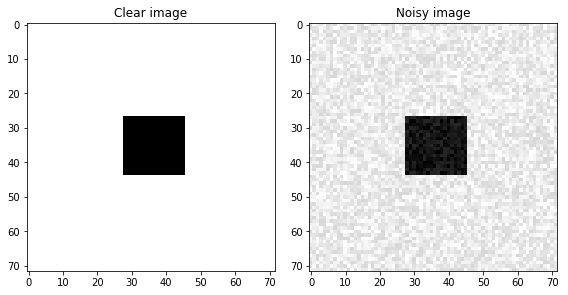

In [115]:
i=np.random.randint(300)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
ax1.imshow(X_train_clear[i].reshape(72,72), cmap='gray')
ax1.set_title("Clear image")

ax2.imshow(X_train_noisy[i].reshape(72,72), cmap='gray')
ax2.set_title("Noisy image")

plt.tight_layout()
plt.show()

In [129]:
input_img = Input(shape=(72, 72, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [123]:
autoencoder = Sequential()

autoencoder.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(72,72,1)))
autoencoder.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

autoencoder.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [124]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 72, 72, 16)        416       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 36, 36, 32)        12832     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 18, 18, 64)        51264     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 9, 9, 128)         204928    
__________

In [121]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 72, 72, 32)        320       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 36, 36, 32)        9248      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 18, 18, 32)        9248      
_________________________________________________________________
up_sampling2d_11 (UpSampling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 36, 36, 32)        9248      
__________

In [127]:
X_train.shape

(300, 72, 72, 1)

In [130]:
autoencoder.fit(X_train_noisy, X_train_clear, epochs=100, batch_size=64)

Epoch 1/100
300/300 [==============================] - 1s 4ms/step - loss: 0.3882
Epoch 2/100
300/300 [==============================] - 0s 726us/step - loss: 0.1769
Epoch 3/100
300/300 [==============================] - 0s 740us/step - loss: 0.1659
Epoch 4/100
300/300 [==============================] - 0s 733us/step - loss: 0.1485
Epoch 5/100
300/300 [==============================] - 0s 731us/step - loss: 0.1337
Epoch 6/100
300/300 [==============================] - 0s 728us/step - loss: 0.1267
Epoch 7/100
300/300 [==============================] - 0s 727us/step - loss: 0.0898
Epoch 8/100
300/300 [==============================] - 0s 732us/step - loss: 0.0815
Epoch 9/100
300/300 [==============================] - 0s 735us/step - loss: 0.0457
Epoch 10/100
300/300 [==============================] - 0s 733us/step - loss: 0.0534
Epoch 11/100
300/300 [==============================] - 0s 732us/step - loss: 0.0288
Epoch 12/100
300/300 [==============================] - 0s 720us/step - loss

Creating data.. Done
Creating data.. Done


In [73]:
autoencoder.evaluate(X_test_noise.reshape(-1, 72, 72, 1), X_test_clean.reshape(-1, 72, 72, 1))

300/300 [==============================] - 0s 751us/step


0.003104393929243088

In [131]:
X_test_clean_pred = autoencoder.predict(X_test_noise)

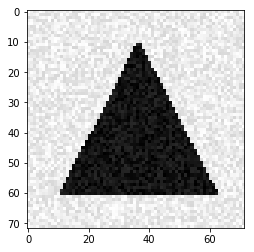

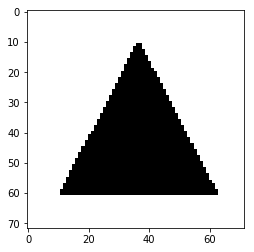

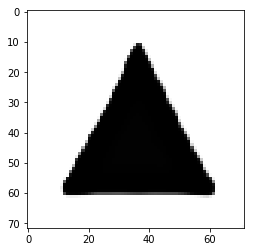

In [132]:
i=np.random.randint(300)

plt.imshow(X_test_noise[i].reshape(72,72), cmap="gray")
plt.show()

plt.imshow(X_test_clean[i].reshape(72,72), cmap="gray")
plt.show()

plt.imshow(X_test_clean_pred[i].reshape(72,72), cmap="gray")
plt.show()